In [1]:
import pickle
import matplotlib.pyplot as plt
from geometry_msgs.msg import Pose
from src.ur10e_custom_control.ur10e_custom_control.ur_exercise_qt import Exercise
import transforms3d
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from geometry_msgs.msg import Vector3, Quaternion

In [2]:
with open("test_pose_trajectory.exercise", "rb") as fp:
    mock_exercise = pickle.load(fp)

In [3]:
mock_exercise: Exercise

In [4]:
def extract_positions_orientations(poses: list[Pose]):
    x_vals, y_vals, z_vals = [], [], []
    frames = []  # Store coordinate frame data
    
    for pose in poses:
        # Extract position
        x_vals.append(pose.position.x)
        y_vals.append(pose.position.y)
        z_vals.append(pose.position.z)

        # Convert quaternion to rotation matrix
        quat = [pose.orientation.x, pose.orientation.y, pose.orientation.z, pose.orientation.w]
        rot_matrix = transforms3d.quaternions.quat2mat(quat)[:3, :3]  # Extract 3x3 rotation
        
        frames.append((pose.position.x, pose.position.y, pose.position.z, rot_matrix))
    
    return x_vals, y_vals, z_vals, frames


In [5]:
x_vals, y_vals, z_vals, frames = extract_positions_orientations(mock_exercise.waypoints)

In [16]:
# Plot 3D Visualization
%matplotlib inline
def plot_3d(x_vals, y_vals, z_vals, frames):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x_vals, y_vals, z_vals, color='blue', label="Positions")

    # Plot frames (X, Y, Z axes)
    frame_scale = 0.01
    for x, y, z, rot_matrix in frames:
        for i, color in enumerate(['r', 'g', 'b']):  # X (red), Y (green), Z (blue)
            ax.quiver(x, y, z, 
                    rot_matrix[0, i] * frame_scale, 
                    rot_matrix[1, i] * frame_scale, 
                    rot_matrix[2, i] * frame_scale, 
                    color=color)

    ax.set_xlabel("X Position")
    ax.set_ylabel("Y Position")
    ax.set_zlabel("Z Position")
    # Function to set equal axes in 3D
    def set_axes_equal(ax):
        """Set equal scale for all axes in a 3D plot."""
        limits = np.array([ax.get_xlim(), ax.get_ylim(), ax.get_zlim()])
        span = limits[:,1] - limits[:,0]
        center = np.mean(limits, axis=1)
        radius = 0.5 * max(span)
        ax.set_xlim(center[0] - radius, center[0] + radius)
        ax.set_ylim(center[1] - radius, center[1] + radius)
        ax.set_zlim(center[2] - radius, center[2] + radius)

    # Apply equal axes
    set_axes_equal(ax)
    ax.set_title("3D Pose Visualization")
    ax.legend()

In [7]:
def rotate_vector_by_quaternion(v, q):
    # Convert vector to quaternion (v, 0) -> (v.x, v.y, v.z, 0)
    v_quat = np.array([0, v[0], v[1], v[2]])
    
    # Perform quaternion multiplication: q * v * q^-1
    q_inv = transforms3d.quaternions.qinverse(q)
    rotated_v_quat = transforms3d.quaternions.qmult(
        transforms3d.quaternions.qmult(q, v_quat), q_inv)
    
    return Quaternion(w=rotated_v_quat[0],x=rotated_v_quat[1],y=rotated_v_quat[2],z=rotated_v_quat[3])

In [14]:
def transform_poses(poses: list[Pose]) -> list[Pose]:
    transformed_poses = []
    for i in range(len(poses)-1):
        t1 = poses[i]
        t2 = poses[i+1]

        v = np.array([
            t2.position.x - t1.position.x,
            t2.position.y - t1.position.y,
            t2.position.z - t2.position.z
        ])

        u = v / np.linalg.norm(v)

        r = np.cross(u, np.array([0, 0, 1]).T)
        theta = np.arccos(np.dot(u, np.array([0, 0, 1]).T))
        q_new = transforms3d.quaternions.axangle2quat(r, theta)
        transformed_poses.append(
            Pose(
                position = t1.position,
                orientation = Quaternion(w=q_new[0], x=q_new[1], y=q_new[2], z=q_new[3])
            )
        )

    transformed_poses.append(poses[-1])
    return transformed_poses

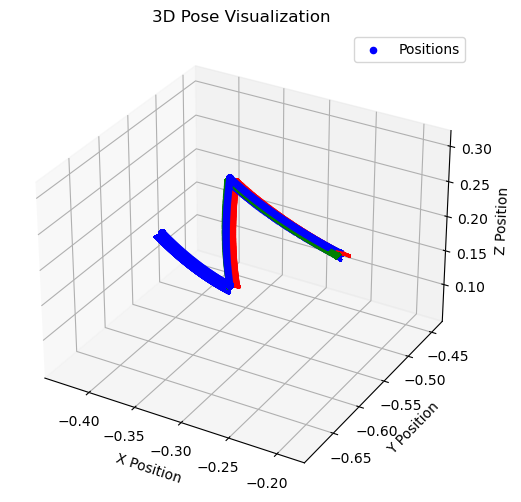

In [19]:
plot_3d(*extract_positions_orientations(mock_exercise.waypoints))

/tmp/ipykernel_419793/569163034.py:13: RuntimeWarning: invalid value encountered in true_divide
  u = v / np.linalg.norm(v)


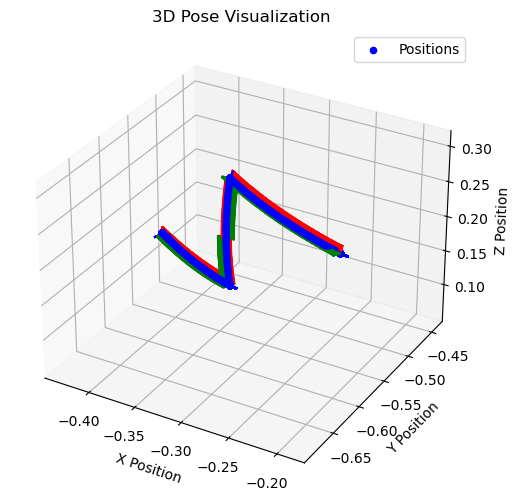

In [17]:
plot_3d(*extract_positions_orientations(transform_poses(mock_exercise.waypoints)))